<a href="https://colab.research.google.com/github/smomtahe/ECGClassification_Wavelets_Open3DPointCloud_FourierTransform_IIR-FIR-Filters/blob/main/ECG_MLClassification_WaveletsSignalProccesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

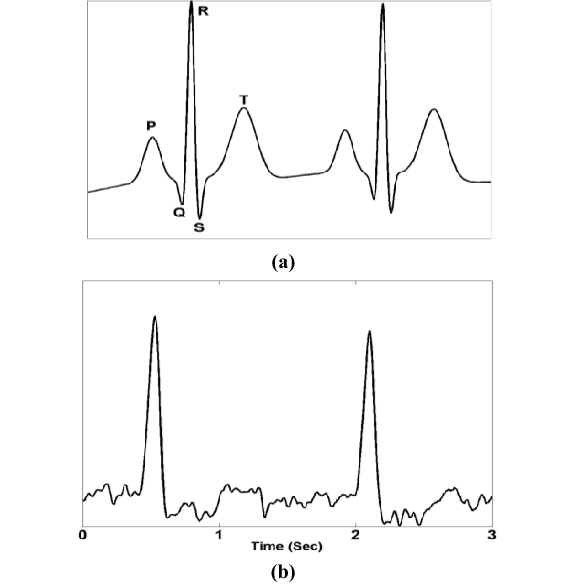

In [7]:
# Electrocardiogram (ECG) measures the electrical activity of heart over a period of time.
# We use Machine learning to classify ECG signals, as normal heartbeat N (a) and abnormal (arrhythmia) (b), like atrial fibrillation (AF).
# I used signals from svbd dataset and grab subsequent beats

from IPython.display import display, Image
display(Image("/content/fig.png"))

# The svdb database (St. Vincent's University Hospital (SVUH)) of ECG signals is used. It contains 75 recordings (lasting 10 seconds each) sampled at 128 Hz, with each recording represented as a pair of files: a binary .dat file containing the ECG signal data and an annotation file providing labels for various events in the ECG signal.
# The binary classifier uses ML algorithms, like neural networks (NN), Decision tress, SVM, or ensemble methods.

In [9]:
# Data prepatration :
## download ECG waves from svdb databased from PhysioNet
## divide signals into samples: each containing singe heartbeat (windiw size : 96 points - sampling ratio = 128 points)
##samples annotated as noraml beat (N) or arrythmias (S or V)

# Install PhysioNet ecg data package
# Installing the wfdb library, which provides tools for reading, writing, and processing physiological waveform data (ECG signals).
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.1 MB/s eta 0:00:00


In [10]:
import os
import numpy as np
import wfdb
# List of available datasets
dbs = wfdb.get_dbs()
display(dbs)

[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['accelerometry-walk-climb-drive',
  'Labeled raw accelerometry data captured during walking, stair climbing and driving'],
 ['actes-cycloergometer-exercise',
  'Cardiorespiratory measurement from graded cycloergometer exercise testing'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-opioid-use-notes',
  'Annotation dataset of problematic opioid use and related contexts from MIMIC-III Critical Care Database discharge summaries'],
 ['antimicrobial-resistance-uti',
  'AMR

In [11]:
# Choose the St. Vincent's University Hospital (SVUH) ECG Database (svdb)
svdb_dir = os.path.join(os.getcwd(), 'svdb_dir')  # Directory to save the downloaded data
wfdb.dl_database('svdb', dl_dir=svdb_dir)  # Download the svdb database

Generating record list for: 800
Generating record list for: 801
Generating record list for: 802
Generating record list for: 803
Generating record list for: 804
Generating record list for: 805
Generating record list for: 806
Generating record list for: 807
Generating record list for: 808
Generating record list for: 809
Generating record list for: 810
Generating record list for: 811
Generating record list for: 812
Generating record list for: 820
Generating record list for: 821
Generating record list for: 822
Generating record list for: 823
Generating record list for: 824
Generating record list for: 825
Generating record list for: 826
Generating record list for: 827
Generating record list for: 828
Generating record list for: 829
Generating record list for: 840
Generating record list for: 841
Generating record list for: 842
Generating record list for: 843
Generating record list for: 844
Generating record list for: 845
Generating record list for: 846
Generating record list for: 847
Generati

In [12]:
# Display the downloaded content (list of .dat files)
# Listing the .dat files (ECG signal files) in the downloaded svdb database directory.
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]

# Printing the list of .dat files in the svdb database directory.
print(svdb_in_files)

['822', '804', '876', '821', '841', '842', '840', '809', '844', '881', '889', '851', '866', '802', '843', '867', '878', '862', '825', '820', '810', '871', '882', '847', '859', '888', '827', '803', '893', '885', '846', '892', '886', '811', '857', '829', '869', '853', '849', '826', '801', '858', '883', '808', '848', '874', '850', '812', '864', '863', '877', '890', '873', '872', '880', '824', '891', '805', '806', '800', '807', '845', '852', '875', '855', '887', '884', '860', '865', '823', '870', '894', '861', '879', '828', '868', '854', '856']


In [13]:
# Define the time window size (it is used to extract beats from the ECG signal: Each beat will consist of 48 samples before and 48 samples after the annotation point.)
time_window = 48

# Initialize lists to store all heartbeats and annotations
all_beats = [] # store the extracted beats
all_annotations = [] # store the corresponding annotations for each beat

# Iterate through each file in svdb_in_files
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file') # svdb_in_files list contains the names of the files in the SVDB database

    # Read ECG signal and annotations
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir, in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir, in_file), 'atr')

    # Flatten signal array to a 1D array
    signal = np.array(signal).flatten()

    # Initialize a 2D array to store subsequent heartbeats within a time window
    beats = np.zeros((len(annotations.sample), time_window * 2))

    # Iterate through annotations to extract beats
    for i, ann_position in enumerate(annotations.sample[5:-5]):  # Exclude first and last beats
        beats[i] = signal[ann_position - time_window:ann_position + time_window] # Extracts a beat from the ECG signal centered around the current annotation position and stores it in the beats array.

    # Append beats and annotations to lists
    all_beats.append(beats)
    all_annotations.append(annotations.symbol[5:-5])  # Exclude first and last annotations

# Concatenate all beats and annotations from different files into single arrays.
all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# Filter annotations to keep only those of classes N, S, or V
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N', 'S', 'V'}]
all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# Print data statistics
# These lines print the shape of the all_beats and all_annotations arrays, & the counts of beats for each annotation class ('N', 'S', and 'V').
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))



...processing...822...file
...processing...804...file
...processing...876...file
...processing...821...file
...processing...841...file
...processing...842...file
...processing...840...file
...processing...809...file
...processing...844...file
...processing...881...file
...processing...889...file
...processing...851...file
...processing...866...file
...processing...802...file
...processing...843...file
...processing...867...file
...processing...878...file
...processing...862...file
...processing...825...file
...processing...820...file
...processing...810...file
...processing...871...file
...processing...882...file
...processing...847...file
...processing...859...file
...processing...888...file
...processing...827...file
...processing...803...file
...processing...893...file
...processing...885...file
...processing...846...file
...processing...892...file
...processing...886...file
...processing...811...file
...processing...857...file
...processing...829...file
...processing...869...file
.

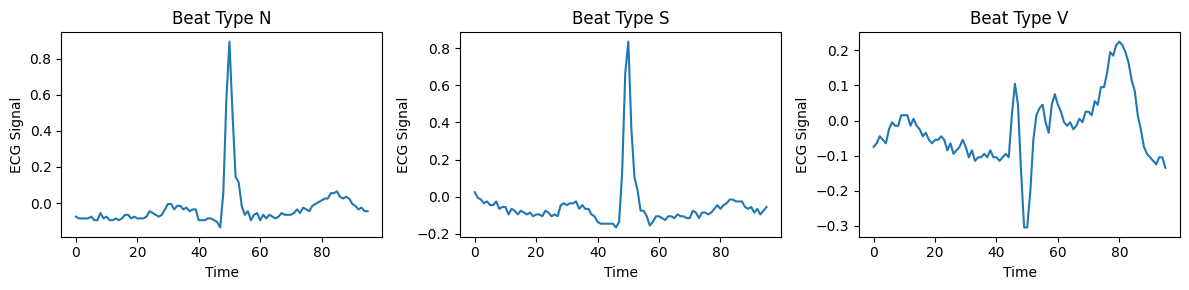

In [36]:
import matplotlib.pyplot as plt

# Define the sample numbers for each beat type to plot
sample_number_N = next((i for i, ann in enumerate(all_annotations) if ann == 'N'), None)
sample_number_S = next((i for i, ann in enumerate(all_annotations) if ann == 'S'), None)
sample_number_V = next((i for i, ann in enumerate(all_annotations) if ann == 'V'), None)

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot ECG vs. time for beat type N
axes[0].plot(all_beats[sample_number_N])
axes[0].set_title('Beat Type N')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('ECG Signal')

# Plot ECG vs. time for beat type S
axes[1].plot(all_beats[sample_number_S])
axes[1].set_title('Beat Type S')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('ECG Signal')

# Plot ECG vs. time for beat type V
axes[2].plot(all_beats[sample_number_V])
axes[2].set_title('Beat Type V')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('ECG Signal')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# "S" beats are abnormal but relatively closer to normal sinus rhythm. They originate above the ventricles.
# "V" beats are extremely abnormal and originate in the ventricles. They are more concerning and can indicate underlying heart conditions.

In [39]:
# Machine Learning: Naive Bayes, SVM, Decision Tree (optimized max_depth), Random Forest (vector of features).
# Dataset: train, validation and test -> normalization -> classification accuracy metrices (imbalanced data)

'''
             Predicted
           |  N  |  S  |  V  |
    ---------------------------
    Actual |-------------------|
     N     |  TN | FP  | FP  |
    ---------------------------
     S     |  FN | TP  | FP  |
    ---------------------------
     V     |  FN | FP  | TP  |
    ---------------------------

True Positives (TP): The cases where the actual class is positive and the model correctly predicts it as positive. For class N, TP is in cell (N, N). For class S, TP is in cell (S, S). For class V, TP is in cell (V, V).
False Positives (FP): The cases where the actual class is negative, but the model incorrectly predicts it as positive. For class N, FP is in cells (N, S) and (N, V). For class S, FP is in cells (S, N) and (S, V). For class V, FP is in cells (V, N) and (V, S).
True Negatives (TN): The cases where the actual class is negative, and the model correctly predicts it as negative. Since there are only three classes, TN can be calculated by subtracting the counts of TP and FP from the total count of samples. For class N, TN = Total - (TP_N + FP_N). For class S, TN = Total - (TP_S + FP_S). For class V, TN = Total - (TP_V + FP_V).
False Negatives (FN): The cases where the actual class is positive, but the model incorrectly predicts it as negative. For class N, FN is in cell (S, N) and (V, N). For class S, FN is in cells (N, S) and (V, S). For class V, FN is in cells (N, V) and (S, V).

'''

# Total Accuracy (AccT) measures the overall accuracy of the classifier across all classes. It calculates the proportion of correctly predicted samples (true positives) for each class (N, S, and V) divided by the total number of predictions made (sum of true positives and false positives) across all classes.
# AccT=(TP_N+TP_S+TP_V)/(ΣN+ΣS+ΣV)
# Arrhythmia Accuracy (AccA) measures the accuracy of the classifier in identifying arrhythmia cases (S or V) relative to the total number of arrhythmia cases in the dataset (sum of samples for classes S and V). It calculates the proportion of correctly predicted samples (true positives) for classes S and V divided by the total number of samples for classes S and V.
# AccA=(TP_S+TP_V)/(ΣS+ΣV)


'\n             Predicted\n           |  N  |  S  |  V  |\n    ---------------------------\n    Actual |-------------------|\n     N     |  TN | FP  | FP  |\n    ---------------------------\n     S     |  FN | TP  | FP  |\n    ---------------------------\n     V     |  FN | FP  | TP  |\n    ---------------------------\n\nTrue Positives (TP): The cases where the actual class is positive and the model correctly predicts it as positive. For class N, TP is in cell (N, N). For class S, TP is in cell (S, S). For class V, TP is in cell (V, V).\nFalse Positives (FP): The cases where the actual class is negative, but the model incorrectly predicts it as positive. For class N, FP is in cells (N, S) and (N, V). For class S, FP is in cells (S, N) and (S, V). For class V, FP is in cells (V, N) and (V, S).\nTrue Negatives (TN): The cases where the actual class is negative, and the model correctly predicts it as negative. Since there are only three classes, TN can be calculated by subtracting the cou

In [40]:
# Prepare datasets and define error metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Speedup training: take only some part of the whole dataset
X, y = all_beats[::5], all_annotations[::5]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)
print(len(y_train), len(y_val), len(y_test))


25718 5512 5512


In [41]:
#  Normalization: z = (x - u)/s
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = preprocessing.StandardScaler().fit_transform(X_val)
X_test = preprocessing.StandardScaler().fit_transform(X_test)

In [42]:
# Accuracy
def calculate_accuracy(y_pred, y_gt, comment='', printout=True):
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(
        np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    if printout is True:
        print('-----------------------------------')
        print(comment)
        print('Total accuracy, Acc_T = {:.4f}'.format(acc_t))
        print('Arrhythmia accuracy, Acc_A = {:.4f}'.format(acc_a))
        print('-----------------------------------')
    else: return acc_t, acc_a

In [43]:
# Classifiers

from sklearn.naive_bayes import GaussianNB
from sklearn import svm

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='Naive Bayes classifier') # perform badly (problem: imbalanced data)

svc = svm.SVC()
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='SVM classifier') # perform better than NB, but still has imbalanced data problem

svc = svm.SVC(class_weight='balanced')
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier') # SVM: after data balancing works good (maximize Acc_T & Acc_A at the same time)

-----------------------------------
naive Bayes classifier
Total accuracy, Acc_T = 0.7847
Arrhythmia accuracy, Acc_A = 0.1543
-----------------------------------
-----------------------------------
SVM classifier
Total accuracy, Acc_T = 0.8917
Arrhythmia accuracy, Acc_A = 0.0614
-----------------------------------
-----------------------------------
balanced SVM classifier
Total accuracy, Acc_T = 0.6471
Arrhythmia accuracy, Acc_A = 0.4425
-----------------------------------


In [44]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced DT')

-----------------------------------
balanced DT
Total accuracy, Acc_T = 0.6544
Arrhythmia accuracy, Acc_A = 0.3433
-----------------------------------


In [47]:
# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy',
                                 class_weight='balanced',
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print(acc_a_val)


0.04264705882352941
0.15735294117647058
0.4176470588235294
0.5014705882352941
0.5705882352941176
0.5235294117647059
0.5367647058823529
0.4308823529411765
0.47941176470588237
0.45294117647058824
0.47205882352941175
0.43823529411764706
0.4161764705882353
0.4176470588235294
0.3941176470588235
0.3514705882352941
0.34558823529411764
0.3382352941176471
0.3323529411764706
0.3014705882352941
0.2926470588235294
0.2911764705882353
0.29558823529411765
0.2867647058823529
0.2867647058823529


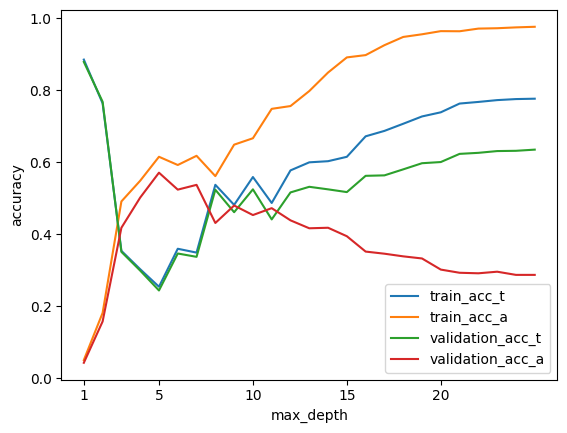

In [48]:
import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train_acc_t')
ax.plot(depth_range, train_acc_a, label='train_acc_a')
ax.plot(depth_range, val_acc_t, label='validation_acc_t')
ax.plot(depth_range, val_acc_a , label='validation_acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20])
ax.legend()
plt.show()

In [51]:
# Optimum acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=10, max_depth=8)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_A_maximized')

# Optimum acc_t & acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=10, max_depth=13)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_T + Acc_A_maximized')
# we considred 2 types of hyperparameters (max_depth and min_samples_leaf) -> tunning -> max value

-----------------------------------
DT: Acc_A_maximized
Total accuracy, Acc_T = 0.5151
Arrhythmia accuracy, Acc_A = 0.4299
-----------------------------------
-----------------------------------
DT: Acc_T + Acc_A_maximized
Total accuracy, Acc_T = 0.5316
Arrhythmia accuracy, Acc_A = 0.4520
-----------------------------------


In [54]:
# PCA (dimensionlality reduction) -> Feature vector
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_ = pca.fit_transform(X_train)
X_test_ = pca.fit_transform(X_test)

dtc = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=5, max_depth=8)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT using PCA:') # works poorly -> DT worse than SVM (DT : overfit)

-----------------------------------
DT using PCA:
Total accuracy, Acc_T = 0.1892
Arrhythmia accuracy, Acc_A = 0.3559
-----------------------------------


In [62]:
# Extract features  from ECG signals using wavelet transformers:
# Wavelets transform signals from the time domain to time-frequncy domain -> detect localized features within signals -> decompose a signal in different frequency components

import pywt # PyWavelets library

# It decomposes the signal into approximation (cA) and detail (cD) coefficients using different wavelet families (each providing different frequency resolution and characteristics) and decomposition levels (4: the signal is decomposed into multiple frequency bands).
# These coefficients capture various frequency components and details of the signal.
# The function computes differences between consecutive samples of the signal and appends them to the feature vector.

def extract_features(input_sample):
    out = np.array([])

    # Wavelet decomposition using different wavelet families ('sym8', 'db6', 'db9', 'dmey') and decomposition levels of 4
    for wavelet in ['sym8', 'db6', 'db9', 'dmey']:
        # approximation coefficients (cA) and detail coefficients (cD) are extracted and appended to the feature vector.
        cA = pywt.downcoef('a', input_sample, wavelet, level=4, mode='per')
        out = np.append(out, cA)
        cD = pywt.downcoef('d', input_sample, wavelet, level=4, mode='per')
        out = np.append(out, cD)

    # Compute differences between consecutive samples and append to the feature vector
    differences = np.zeros(16)
    for i, t in enumerate(range(40, 56)):
        differences[i] = input_sample[t + 1] - input_sample[t]
    out = np.append(out, differences)

    return out

# It returns a matrix where each row represents the feature vector extracted from a single ECG signal. -> preprocessed featire matrices : input to tarine below classfiers.
# The classifiers learn to predict the class labels (e.g., normal heartbeat, arrhythmia) based on the extracted features.


SyntaxError: invalid syntax (<ipython-input-62-d51c95d8f1eb>, line 30)

In [56]:
# Data Preprocessing by extracting features using extract_features():
def data_features(input_data):
    return np.array([extract_features(sample) for sample in input_data]) # returns a matrix where each row represents the feature vector for a single input sample.


In [57]:
# Model Training and Evaluation:
X_train_ = data_features(X_train)
print(X_train_.shape)
X_test_ = data_features(X_test)
print(X_test_.shape)


(25718, 64)
(5512, 64)


In [58]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=10, max_depth=8)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with wavelets')


-----------------------------------
DT with wavelets
Total accuracy, Acc_T = 0.6112
Arrhythmia accuracy, Acc_A = 0.3764
-----------------------------------


In [63]:
# Ensemble learning:
from sklearn.ensemble import BaggingClassifier

# Bagging Classifier
bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=10, max_depth=8), n_estimators=50, max_samples=0.5, max_features=0.5)
y_pred = bc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='Bagging with Decision Tree')



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


-----------------------------------
Bagging with Decision Tree
Total accuracy, Acc_T = 0.6856
Arrhythmia accuracy, Acc_A = 0.3921
-----------------------------------


In [60]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', n_estimators=1000, max_depth=8, class_weight='balanced')
y_pred = rfc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='RF with wavelets')


-----------------------------------
RF with wavelets
Total accuracy, Acc_T = 0.6783
Arrhythmia accuracy, Acc_A = 0.4236
-----------------------------------
